# Understand the problems
## Context
Having csv file containing information about car listings. Defined tasks:
1. Build a model
- Work on brands make up 90% of the total cars -> Maybe filtering is a good option. 
- Predict the price of used cars -> Regression task
2. Define a success metrics 
- Maybe metrics related to regression tasks, including:
    - functional metrics -> MSE, R-squared
    - non-functional metrics -> inference time per request, 
3. Build an API
- Objective is to develop a RESTful API for the model mentioned above -> Since this is a demo, maybe i will stick with FastAPI for a fast demo.
4. Data Analysis Questions
- How does mileage relate to car price? Is there a clear negative correlation? -> I think this question is more data-centric instead of model-centric, therefore using modeling techniques like SHAP value to interprete maybe is not suitable. Thus, sticking with statistic methods maybe more general. 
- Does the fuel type (petrol, diesel, etc.) have a noticeable impact on price? -> I can reframe this question as is fuel type is statistical significant with the price -> Maybe using statistics test -> Using some libraries. 
- How to compare two cars in the same segment? -> Still thinking (what is segment mean?)

## Scoring objective:
- How well does your model perform -> This maybe strongly related to the chosen metrics. 
- How effective is the selected metric in evaluating model performance -> Are these metrics align with what people are doing in real-life problem?
- How could your model be improved? -> Tbh, both modeling and data preparation are needed in order to improve the model's prediction. 

# Import libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sys

In [2]:
# Load data
DATA_PATH = 'data/raw'
MODEL_PATH = 'models'
ref = pd.read_csv(f'{DATA_PATH}/car.csv') # for reference if needed
data = pd.read_csv(f'{DATA_PATH}/car.csv')

In [3]:
unique_df = ref[~ref.duplicated()]
unique_df

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,148468232,108616925,1693378633111,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,149530234,109517456,1693313503000,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317611,150748445,110565749,1696580444000,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317613,150811050,110619804,1696753826000,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used
317617,150840647,110645035,1696835873000,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used
317618,148874300,108958993,1696836032000,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,NaN,110000,535000000.0,used


In [4]:
# Take a random sample
sample_record = data.sample(n=1)

# Convert the sample record to a dictionary
sample_dict = sample_record.to_dict(orient='records')[0]

print(sample_dict)

{'id': 149983394, 'list_id': 109907153, 'list_time': 1694593062000, 'manufacture_date': 2020, 'brand': 'Vinfast', 'model': 'Fadil', 'origin': 'Việt Nam', 'type': 'Hatchback', 'seats': 5.0, 'gearbox': 'AT', 'fuel': 'petrol', 'color': 'red', 'mileage_v2': 40000, 'price': 338000000.0, 'condition': 'used'}


# EDA and Preprocessing

## Overview

In [5]:
# Check for the shape of the data
data.shape

(317636, 15)

Currently, the data has 317636 rows  with 15 columns

In [6]:
# Check for the first 5 rows of the data
data.head()

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,148468232,108616925,1693378633111,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,149530234,109517456,1693313503000,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used


This is what the first 5 records look like. It seems that id, list_id, list_time are quite vague -> need to ask stakeholders about the data dictionary.

In [7]:
# We care for some statistics of the data
data.describe()

,id,list_id,list_time,manufacture_date,seats,mileage_v2,price
count,3.176360e+05,3.176360e+05,3.176360e+05,317636.00000,283792.000000,317636.000000,3.175240e+05
mean,1.489581e+08,1.090510e+08,1.695835e+12,2016.53675,5.712529,61327.917528,6.265541e+08
std,3.484644e+06,2.878699e+06,1.131473e+09,26.07318,1.780515,92679.788593,7.284020e+08
min,4.588559e+07,2.989052e+07,1.691400e+12,-1.00000,-1.000000,0.000000,1.310720e+06
25%,1.490832e+08,1.091366e+08,1.695113e+12,2014.00000,5.000000,9000.000000,3.150000e+08
50%,1.499784e+08,1.099032e+08,1.695873e+12,2019.00000,5.000000,42000.000000,4.900000e+08
75%,1.504550e+08,1.103140e+08,1.696577e+12,2022.00000,7.000000,82000.000000,7.150000e+08
max,1.513698e+08,1.110970e+08,1.698210e+12,2023.00000,16.000000,999999.000000,3.750000e+10


We can see that manufacture_date and seats has negative values in it, which impose errors. We should drop those records as well.

In [8]:
data.describe(include='object')

,brand,model,origin,type,gearbox,fuel,color,condition
count,317586,317586,234317,272934,316243,317542,221540,317636
unique,67,521,10,9,4,4,12,2
top,Toyota,Ranger,Việt Nam,Sedan,AT,petrol,white,used
freq,65455,15719,116368,90709,239222,259244,72035,270089


We can see that there are 67 brands and 521 models in total, however there may be some duplicate as well. Which make statistics unreliable.

In [9]:
# Drop the id, list_id, list_time columns
data = data.drop(['id', 'list_id', 'list_time'], axis=1)

In [10]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317631,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,NaN,110000,535000000.0,used
317632,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317633,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317634,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used


Ok, so now we drop useless columns, we can further investigate the records.

## Convert data types

In [11]:
# Check for the data types of the columns
data.dtypes

manufacture_date      int64
brand                object
model                object
origin               object
type                 object
seats               float64
gearbox              object
fuel                 object
color                object
mileage_v2            int64
price               float64
condition            object
dtype: object

In [12]:
# Convert data types of the columns
data['brand'] = data['brand'].astype('category')
data['model'] = data['model'].astype('category')
data['origin'] = data['origin'].astype('category')    
data['gearbox'] = data['gearbox'].astype('category')
data['fuel'] = data['fuel'].astype('category')
data['type'] = data['type'].astype('category')
data['color'] = data['color'].astype('category')
data['condition'] = data['condition'].astype('category')
data.dtypes

manufacture_date       int64
brand               category
model               category
origin              category
type                category
seats                float64
gearbox             category
fuel                category
color               category
mileage_v2             int64
price                float64
condition           category
dtype: object

We have to convert the data back to the correct data type. Although in some scenario, object and category can be used interchangeably, I still prefer category over object, especially for these variable.

## Handling duplicate

In [13]:
# Display several duplicates
duplicates = data[data.duplicated(keep=False) | data.duplicated(keep='first')]
duplicates.sort_values(by=list(duplicates.columns))

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
44958,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
44959,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
58892,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
58893,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
79332,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
...,...,...,...,...,...,...,...,...,...,...,...,...
19763,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used
41234,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used
41235,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used
56436,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used


We can say that the data is duplicate a lot. Therefore I will decide to drop those duplicated columns. Additionally, some error data also occurs in the dataset as well. We will need to remove them too.

In [14]:
data = data.drop_duplicates()
print(f'The data now has: {data.shape[0]} rows and {data.shape[1]} columns')

The data now has: 42083 rows and 12 columns


In [15]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317613,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used


In [21]:
feature_cols = data.columns.tolist().remove('price')

The size of the data has been dramatically decrease. However, the sale price of the car can also be effected by the perspective of the seller. Therefore, some scenarios where different salers have different prices for the same car. We will comeback to this step later, after we dealing with missing values, and after that, we can define those records again.

## Handling missing values

In [25]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,4,0.009505,category
model,4,0.009505,category
origin,12174,28.928546,category
type,5932,14.095953,category
seats,4724,11.225435,float64
gearbox,190,0.451489,category
fuel,6,0.014258,category
color,13036,30.976879,category
mileage_v2,0,0.000000,int64


If we put ourselves under the view of the buyer, we will definately not buy the car if we do not know what brand it was or what model it was. Therefore these fields may be very important to determine the sale price of the car. With that being said, I will drop records where brand, model and price is empty. 

In [26]:
# Records with missing values in the 'price','brand','model' column
# Select and print records with missing values in 'brand', 'model', and 'price'
missing_records = data[data[['brand', 'model', 'price']].isnull().any(axis=1)]
print("Records with missing values in 'brand', 'model', and 'target':")
missing_records

Records with missing values in 'brand', 'model', and 'target':


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1059,2023,Hyundai,Grand i10,Việt Nam,NaN,5.0,AT,petrol,NaN,0,NaN,new
1727,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,90000,190000000.0,used
5517,2005,Ford,Transit,NaN,Van,16.0,MT,oil,NaN,280000,NaN,used
12848,2023,Ford,Everest,Thái Lan,SUV / Cross over,7.0,AT,oil,NaN,0,NaN,new
20958,2022,Suzuki,Ertiga,Nước khác,NaN,7.0,AT,hybrid,NaN,0,NaN,new
22164,2023,Hyundai,Accent,Việt Nam,Sedan,5.0,AT,petrol,white,0,NaN,new
23120,2023,Hyundai,Accent,Hàn Quốc,Sedan,5.0,AT,petrol,white,0,NaN,new
44958,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,890000000.0,used
159136,2011,Toyota,Fortuner,Việt Nam,SUV / Cross over,7.0,AT,petrol,silver,110000,NaN,used
165378,2022,Hyundai,Stargazer,Hàn Quốc,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new


Maybe I will keep records with missing price for later inferencing (if these records are missing the price only). The remains can be dropped.

In [27]:
# Keep records with missing 'price' only
missing_price_only = data[data['price'].isnull() & data.drop(columns=['price']).notnull().all(axis=1)]
print("Records with missing 'price' only:")
missing_price_only

Records with missing 'price' only:


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
22164,2023,Hyundai,Accent,Việt Nam,Sedan,5.0,AT,petrol,white,0,NaN,new
23120,2023,Hyundai,Accent,Hàn Quốc,Sedan,5.0,AT,petrol,white,0,NaN,new
159136,2011,Toyota,Fortuner,Việt Nam,SUV / Cross over,7.0,AT,petrol,silver,110000,NaN,used
165378,2022,Hyundai,Stargazer,Hàn Quốc,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new
169034,2023,Hyundai,Custin,Việt Nam,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new
181000,2022,Hyundai,Stargazer,Nước khác,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new
181926,2022,Hyundai,Stargazer,Nước khác,Minivan (MPV),7.0,AT,petrol,black,0,NaN,new


In [28]:
missing_price_only.to_csv((f'{DATA_PATH}/inference.csv'), index=False)
data = data[~data.index.isin(missing_records.index)]


In [29]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,12166,28.923969,category
type,5924,14.083971,category
seats,4719,11.219153,float64
gearbox,190,0.451714,category
fuel,2,0.004755,category
color,13023,30.961438,category
mileage_v2,0,0.000000,int64


Ok, now we need to further investigate to see what we can do to the remaining missing values. 

In [30]:
# Overall statistics of the data
data.describe(include='all')

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
count,42062.000000,42062,42062,29896,36138,37343.000000,41872,42060,29039,42062.000000,4.206200e+04,42062
unique,NaN,67,521,10,9,NaN,4,4,12,NaN,NaN,2
top,NaN,Toyota,Innova,Việt Nam,Sedan,NaN,AT,petrol,white,NaN,NaN,used
freq,NaN,8957,2067,14697,12489,NaN,30162,34847,9358,NaN,NaN,38343
mean,2016.082640,NaN,NaN,NaN,NaN,5.661945,NaN,NaN,NaN,70524.350601,5.677237e+08,NaN
std,6.370362,NaN,NaN,NaN,NaN,1.737503,NaN,NaN,NaN,103365.243520,7.137355e+08,NaN
min,1980.000000,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,0.000000,1.310720e+06,NaN
25%,2013.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,14000.000000,2.750000e+08,NaN
50%,2018.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,50000.000000,4.500000e+08,NaN
75%,2021.000000,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,90000.000000,6.500000e+08,NaN


Seats also have a values where it is equal to -1, which is obviously wrong :). Detect and drop those as well. 

In [31]:
# Drop rows where seats is less than or equal to 0
data = data[data['seats'] > 0]

data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317613,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used


In [32]:
data.describe(include='all')

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
count,37222.000000,37222,37222,28757,35511,37222.000000,37032,37222,28181,37222.000000,3.722200e+04,37222
unique,NaN,66,481,10,9,NaN,3,4,12,NaN,NaN,2
top,NaN,Toyota,Innova,Việt Nam,Sedan,NaN,AT,petrol,white,NaN,NaN,used
freq,NaN,8078,1914,14246,12332,NaN,26820,30766,9044,NaN,NaN,33557
mean,2016.252593,NaN,NaN,NaN,NaN,5.683601,NaN,NaN,NaN,69975.821718,5.624639e+08,NaN
std,6.178039,NaN,NaN,NaN,NaN,1.698230,NaN,NaN,NaN,101096.358858,6.318453e+08,NaN
min,1980.000000,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,0.000000,1.310720e+06,NaN
25%,2013.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,14278.250000,2.820000e+08,NaN
50%,2018.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,50000.000000,4.550000e+08,NaN
75%,2021.000000,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,90000.000000,6.500000e+08,NaN


In [33]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,8465,22.741927,category
type,1711,4.596744,category
seats,0,0.000000,float64
gearbox,190,0.510451,category
fuel,0,0.000000,category
color,9041,24.289399,category
mileage_v2,0,0.000000,int64


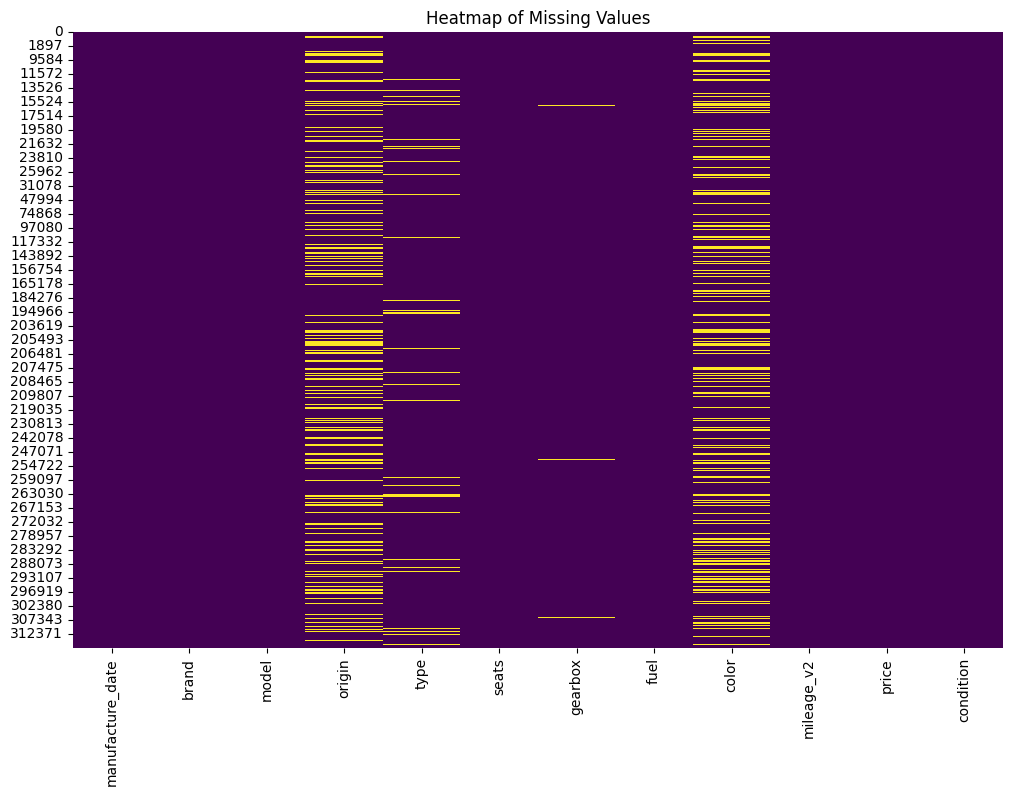

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

We can see that there is some missing regions, my best guests is that something must went wrong in the data gathering process, which lead to this bizard situations. I suspect that some brand and models are so unique such that it only have one type/origin or so on. I will need to investigate on that as well. 

In [35]:
# Group by 'brand' and 'model' and count occurrences
brand_model_counts = data.groupby(['brand', 'model']).size().reset_index(name='count')
# Sort the values in descending order
brand_model_counts = brand_model_counts.sort_values(by='count', ascending=False)

/tmp/ipykernel_39428/3156361840.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_model_counts = data.groupby(['brand', 'model']).size().reset_index(name='count')


In [36]:
# Identify unique or rare combinations
unique_combinations = brand_model_counts[(brand_model_counts['count'] >= 1) & (brand_model_counts['count'] <= 5)]
# Filter the original DataFrame to get records with unique combinations
unique_records = data[data.set_index(['brand', 'model']).index.isin(unique_combinations.set_index(['brand', 'model']).index)]
print("Records with unique or rare brand and model combinations:")
unique_records

Records with unique or rare brand and model combinations:


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
76,2023,Hyundai,County,Việt Nam,Minivan (MPV),7.0,AT,petrol,black,0,848000000.0,new
1264,1980,Jeep,Dòng khác,Mỹ,NaN,4.0,AT,petrol,NaN,20000,200000000.0,used
1301,2005,Suzuki,Alto,NaN,NaN,2.0,MT,petrol,NaN,6789,58000000.0,used
1341,2003,Hyundai,Libero,Hàn Quốc,Pick-up (bán tải),4.0,MT,oil,white,262000,125000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
315307,1995,Jeep,CJ,Trung Quốc,NaN,5.0,MT,petrol,others,145874,80000000.0,used
316805,2013,SYM,T880,Hàn Quốc,Van,5.0,MT,petrol,gold,8888,68000000.0,used
317147,1980,Jeep,CJ,Mỹ,Mui trần,4.0,MT,petrol,red,10000,132000000.0,used
317166,1997,Lada,Dòng khác,Nhật Bản,Sedan,5.0,MT,hybrid,blue,1235,10000000.0,used


In [37]:
# Check if there is any missing values in these records
unique_records_missing = unique_records.isnull().sum()
unique_records_missing 

manufacture_date     0
brand                0
model                0
origin              45
type                74
seats                0
gearbox              0
fuel                 0
color               77
mileage_v2           0
price                0
condition            0
dtype: int64

I don't see how this can be integrate with the current workflow. However, people should not selling cars which the origin of the cars is unknown, and because the origin is unknown, we can not sell the car legally (Based on this link: https://www.baogiaothong.vn/he-luy-khi-mua-xe-khong-giay-to-192240319074428423.htm). With that being said, car with unknown origin should be dropped since it may cause unpredictable effect when aligning between business logic and model logic.

In [38]:
data = data.dropna(subset=['origin'])
print(f'The data now has: {data.shape[0]} rows and {data.shape[1]} columns')

The data now has: 28757 rows and 12 columns


In [39]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used


In [41]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,0,0.000000,category
type,1379,4.795354,category
seats,0,0.000000,float64
gearbox,119,0.413812,category
fuel,0,0.000000,category
color,3927,13.655806,category
mileage_v2,0,0.000000,int64


Now the remaining problems is how to deal with origin, type and color. When we reach this step, I think that visualization will be a very powerful tool. So let dive in !

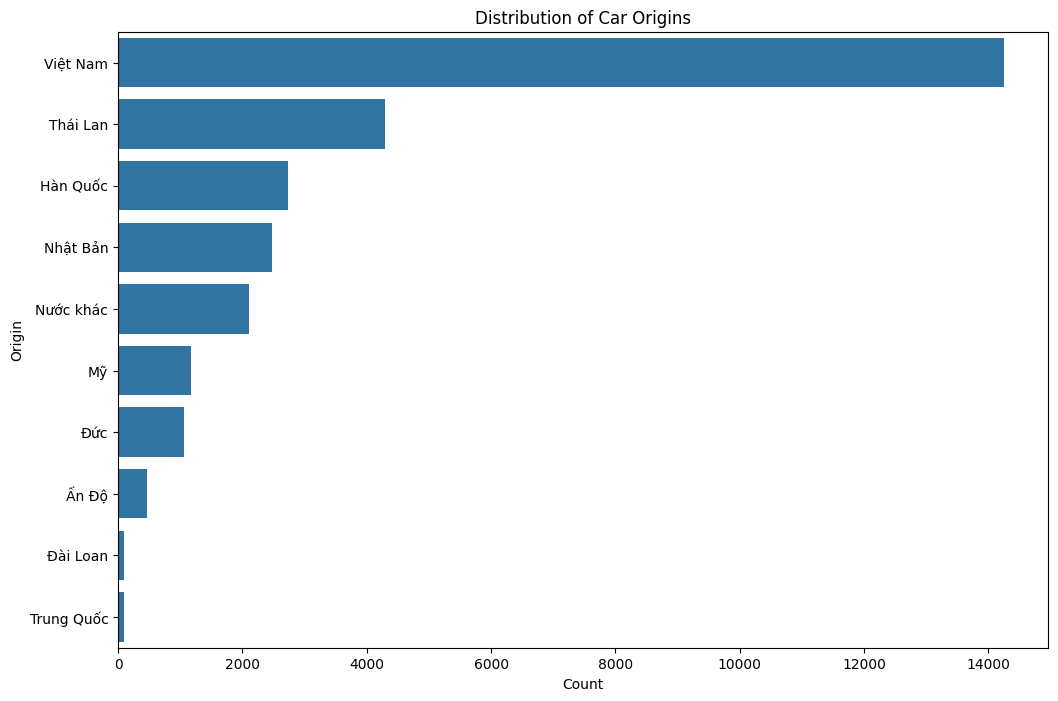

In [42]:
# Print the plot of origin
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='origin', order=data['origin'].value_counts().index)
plt.title('Distribution of Car Origins')
plt.xlabel('Count')
plt.ylabel('Origin')
plt.show()

In [43]:
# Print unique value for type of car
data['type'].unique()

['SUV / Cross over', 'Sedan', 'Minivan (MPV)', 'Hatchback', 'Pick-up (bán tải)', NaN, 'Coupe (2 cửa)', 'Kiểu dáng khác', 'Van', 'Mui trần']
Categories (9, object): ['Coupe (2 cửa)', 'Hatchback', 'Kiểu dáng khác', 'Minivan (MPV)', ..., 'Pick-up (bán tải)', 'SUV / Cross over', 'Sedan', 'Van']

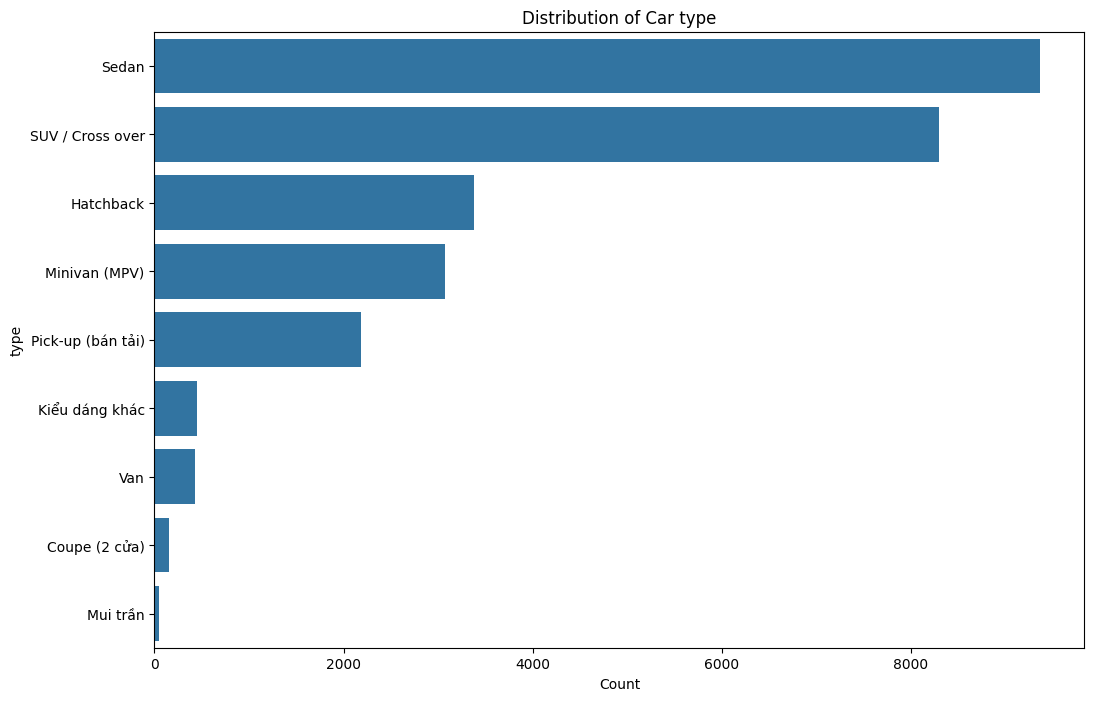

In [44]:
# Print the plot of car type
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='type', order=data['type'].value_counts().index)
plt.title('Distribution of Car type')
plt.xlabel('Count')
plt.ylabel('type')
plt.show()

In [45]:
# Print unique color of cars
data['color'].unique()

['green', 'white', 'black', NaN, 'grey', ..., 'blue', 'red', 'orange', 'pink', 'brown']
Length: 13
Categories (12, object): ['black', 'blue', 'brown', 'gold', ..., 'pink', 'red', 'silver', 'white']

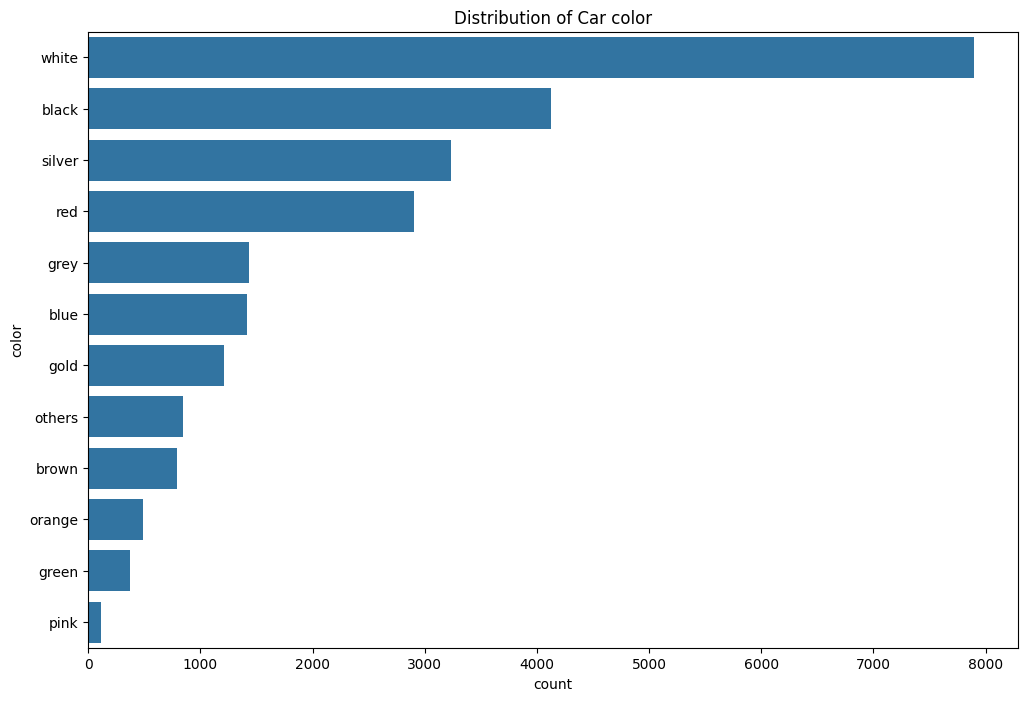

In [46]:
# Print the plot of origin
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='color', order=data['color'].value_counts().index)
plt.title('Distribution of Car color')
plt.ylabel('color')
plt.show()

In [48]:
# Print unique colors of gearboxes
data['gearbox'].unique()

['MT', 'AT', 'AMT', NaN]
Categories (4, object): ['AMT', 'AT', 'MT', 'unknown']

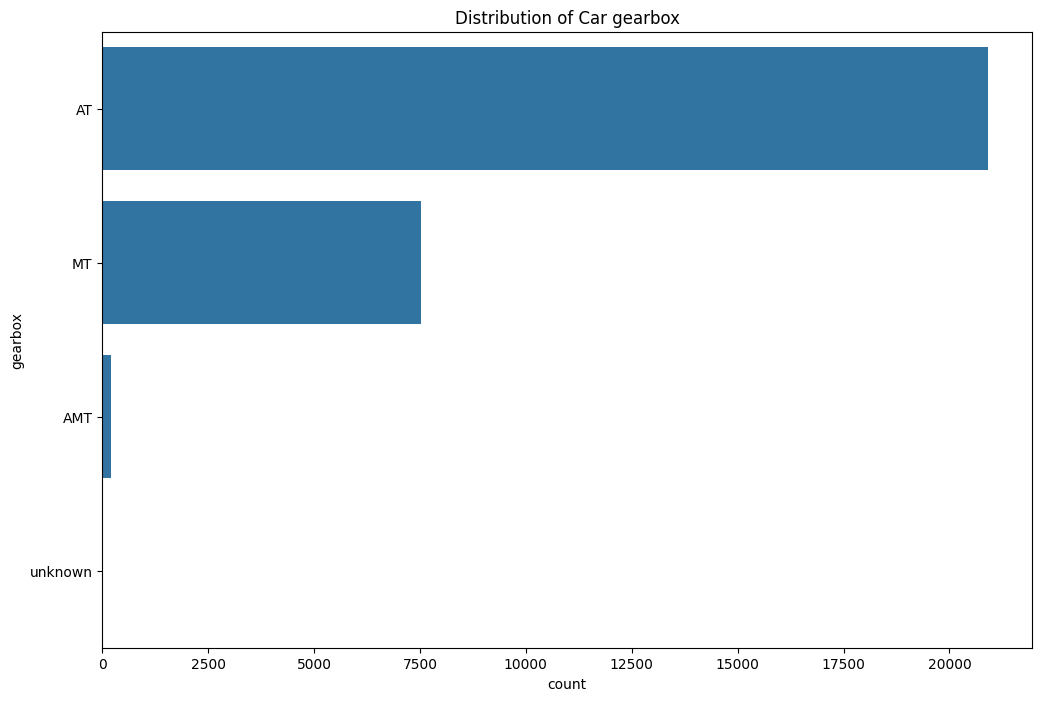

In [49]:
# Print the plot of gearboxes
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='gearbox', order=data['gearbox'].value_counts().index)
plt.title('Distribution of Car gearbox')
plt.ylabel('gearbox')
plt.show()

There is nothing much i can do now without having a deep knowledge for cars. Therefore the safe option is to change the NaN values to unknown.

### Comback to handle duplicate values

In [53]:
exp_data = data.copy()
exp_data.columns.to_list()

['manufacture_date',
 'brand',
 'model',
 'origin',
 'type',
 'seats',
 'gearbox',
 'fuel',
 'color',
 'mileage_v2',
 'price',
 'condition']

In [56]:
# Define feature cols
feature_cols = ['manufacture_date',
 'brand',
 'model',
 'origin',
 'type',
 'seats',
 'gearbox',
 'fuel',
 'color',
 'mileage_v2',
 'condition']
# Create a new column by concatenating other columns
exp_data['concatenated'] = exp_data[feature_cols].astype(str).agg('_'.join, axis=1)

# Check for duplicates in the concatenated column but with different prices
duplicates_with_diff_price = exp_data[exp_data.duplicated(subset=['concatenated'], keep=False) & exp_data.duplicated(subset=['concatenated', 'price'], keep=False) == False]

duplicates_with_diff_price[['concatenated', 'price']].sort_values(by='concatenated').tail()

,concatenated,price
104120,2023_Volkswagen_Virtus_Ấn Độ_Sedan_5.0_AT_petr...,6.990000e+08
21706,2023_Volvo_S90_Nước khác_Sedan_5.0_AT_petrol_b...,2.140000e+09
18684,2023_Volvo_S90_Việt Nam_Sedan_5.0_AT_petrol_bl...,2.145000e+09
88520,2023_Volvo_S90_Việt Nam_Sedan_5.0_AT_petrol_bl...,2.099000e+09
19762,2023_Volvo_S90_Đức_Sedan_5.0_AT_petrol_black_3...,2.099000e+09


In [59]:
# Identify duplicates based on the concatenated values
exp_duplicated = duplicates_with_diff_price[duplicates_with_diff_price.duplicated('concatenated', keep=False)]

# Display the duplicate records
exp_duplicated.sort_values(by='concatenated')

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
8144,1980,Jeep,Dòng khác,Mỹ,NaN,4.0,AT,petrol,NaN,20000,1.900000e+08,used,1980_Jeep_Dòng khác_Mỹ_nan_4.0_AT_petrol_nan_2...
1264,1980,Jeep,Dòng khác,Mỹ,NaN,4.0,AT,petrol,NaN,20000,2.000000e+08,used,1980_Jeep_Dòng khác_Mỹ_nan_4.0_AT_petrol_nan_2...
309187,1980,Jeep,Wrangler,Mỹ,Mui trần,5.0,MT,oil,green,187642,4.300000e+07,used,1980_Jeep_Wrangler_Mỹ_Mui trần_5.0_MT_oil_gree...
308996,1980,Jeep,Wrangler,Mỹ,Mui trần,5.0,MT,oil,green,187642,4.700000e+07,used,1980_Jeep_Wrangler_Mỹ_Mui trần_5.0_MT_oil_gree...
308186,1980,Jeep,Wrangler,Mỹ,Mui trần,5.0,MT,oil,green,187642,5.700000e+07,used,1980_Jeep_Wrangler_Mỹ_Mui trần_5.0_MT_oil_gree...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,2023,Volkswagen,Touareg,Đức,SUV / Cross over,5.0,AT,petrol,others,0,3.348000e+09,new,2023_Volkswagen_Touareg_Đức_SUV / Cross over_5...
38032,2023,Volkswagen,Touareg,Đức,Sedan,5.0,AT,petrol,white,0,2.899000e+09,new,2023_Volkswagen_Touareg_Đức_Sedan_5.0_AT_petro...
83564,2023,Volkswagen,Touareg,Đức,Sedan,5.0,AT,petrol,white,0,2.699000e+09,new,2023_Volkswagen_Touareg_Đức_Sedan_5.0_AT_petro...
88520,2023,Volvo,S90,Việt Nam,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used,2023_Volvo_S90_Việt Nam_Sedan_5.0_AT_petrol_bl...


Based on what we have observed, it is safe to say that different people truly sale their car differently eventhough the configuration was the same. Therefore in order to minimize the error, I suggest we group them and take the average of the price

In [60]:
exp_merge_price = exp_duplicated.groupby('concatenated').agg({'price': 'mean'}).reset_index()

In [61]:
exp_merge_price

,concatenated,price
0,1980_Jeep_Dòng khác_Mỹ_nan_4.0_AT_petrol_nan_2...,1.950000e+08
1,1980_Jeep_Wrangler_Mỹ_Mui trần_5.0_MT_oil_gree...,4.900000e+07
2,1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_pe...,2.666667e+07
3,1980_Toyota_Dòng khác_Nhật Bản_Sedan_5.0_MT_pe...,1.045000e+08
4,1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol...,3.550000e+07
...,...,...
4081,2023_Volkswagen_Touareg_Nước khác_SUV / Cross ...,2.799000e+09
4082,2023_Volkswagen_Touareg_Nước khác_nan_5.0_AT_p...,2.849000e+09
4083,2023_Volkswagen_Touareg_Đức_SUV / Cross over_5...,3.048667e+09
4084,2023_Volkswagen_Touareg_Đức_Sedan_5.0_AT_petro...,2.799000e+09


Okay, so far so good, now we have carefully handle records where the same configurations appear frequently. Now we need to merge it with the data, then remove duplicated as before.

In [63]:
data['concatenated'] = data[feature_cols].astype(str).agg('_'.join, axis=1)
data

/tmp/ipykernel_39428/242004034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['concatenated'] = data[feature_cols].astype(str).agg('_'.join, axis=1)


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used,1980_Jeep_A2_Mỹ_SUV / Cross over_4.0_MT_petrol...
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,2021_Honda_City_Nhật Bản_Sedan_5.0_AT_petrol_w...
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,2020_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,2022_Hyundai_Elantra_Việt Nam_Sedan_5.0_AT_pet...
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used,2018_Toyota_Innova_Việt Nam_SUV / Cross over_8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,2019_Hyundai_Accent_Việt Nam_Sedan_5.0_MT_petr...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,2017_Kia_Sedona_Việt Nam_Minivan (MPV)_7.0_AT_...
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used,2004_Ssangyong_Musso_Hàn Quốc_SUV / Cross over...
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used,2018_Hyundai_Grand i10_Việt Nam_Hatchback_5.0_...


In [67]:
# Create a dictionary from exp_merge_price for efficient lookup
price_dict = dict(zip(exp_merge_price['concatenated'], exp_merge_price['price']))
price_dict

{'1980_Jeep_Dòng khác_Mỹ_nan_4.0_AT_petrol_nan_20000_used': 195000000.0,
 '1980_Jeep_Wrangler_Mỹ_Mui trần_5.0_MT_oil_green_187642_used': 49000000.0,
 '1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_petrol_blue_200000_used': 26666666.666666668,
 '1980_Toyota_Dòng khác_Nhật Bản_Sedan_5.0_MT_petrol_white_123_used': 104500000.0,
 '1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol_blue_123123_used': 35500000.0,
 '1984_Mercedes Benz_Dòng khác_Nước khác_Sedan_5.0_MT_petrol_black_200000_used': 16999999.5,
 '1984_Toyota_Corolla_Nhật Bản_Sedan_5.0_MT_petrol_blue_59000_used': 19500000.0,
 '1985_Nissan_Sentra_Nhật Bản_Sedan_5.0_MT_petrol_green_99999_used': 27500000.0,
 '1985_Toyota_Corona_Nhật Bản_Sedan_4.0_MT_petrol_pink_200000_used': 26200000.0,
 '1985_Toyota_Dòng khác_Nhật Bản_Van_9.0_AT_petrol_silver_29_used': 39750000.0,
 '1986_Chrysler_LeBaron_Mỹ_Sedan_5.0_MT_petrol_black_178978_used': 21500000.0,
 '1987_Honda_Accord_Nhật Bản_Sedan_5.0_MT_petrol_grey_100000_used': 48666666.666666664,
 '1987_Nissan

In [69]:
another_data = data.copy()
another_data['price'] = another_data['concatenated'].map(price_dict).fillna(another_data['price'])
another_data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used,1980_Jeep_A2_Mỹ_SUV / Cross over_4.0_MT_petrol...
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,2021_Honda_City_Nhật Bản_Sedan_5.0_AT_petrol_w...
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,2020_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,2022_Hyundai_Elantra_Việt Nam_Sedan_5.0_AT_pet...
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used,2018_Toyota_Innova_Việt Nam_SUV / Cross over_8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,2019_Hyundai_Accent_Việt Nam_Sedan_5.0_MT_petr...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,2017_Kia_Sedona_Việt Nam_Minivan (MPV)_7.0_AT_...
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used,2004_Ssangyong_Musso_Hàn Quốc_SUV / Cross over...
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,310000000.0,used,2018_Hyundai_Grand i10_Việt Nam_Hatchback_5.0_...


In [70]:
another_data = another_data.drop_duplicates()
another_data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used,1980_Jeep_A2_Mỹ_SUV / Cross over_4.0_MT_petrol...
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,2021_Honda_City_Nhật Bản_Sedan_5.0_AT_petrol_w...
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,2020_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,2022_Hyundai_Elantra_Việt Nam_Sedan_5.0_AT_pet...
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used,2018_Toyota_Innova_Việt Nam_SUV / Cross over_8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317587,2014,SYM,Dòng khác,Đài Loan,Coupe (2 cửa),4.0,MT,oil,NaN,900000,15000000.0,used,2014_SYM_Dòng khác_Đài Loan_Coupe (2 cửa)_4.0_...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,2019_Hyundai_Accent_Việt Nam_Sedan_5.0_MT_petr...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,2017_Kia_Sedona_Việt Nam_Minivan (MPV)_7.0_AT_...
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used,2004_Ssangyong_Musso_Hàn Quốc_SUV / Cross over...


In [71]:
another_data = another_data.drop('concatenated', axis=1)

Ok so there is no more problem with duplicate data. We can move on and deal with missing values

In [39]:
# Convert NaN or Null values to 'Unknown' in categorical columns
categorical_columns = data.select_dtypes(include='category').columns

for col in categorical_columns:
    data[col] = data[col].cat.add_categories('Unknown').fillna('Unknown')

/tmp/ipykernel_27798/3394615404.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].cat.add_categories('Unknown').fillna('Unknown')


In [40]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.0,int64
brand,0,0.0,category
model,0,0.0,category
origin,0,0.0,category
type,0,0.0,category
seats,0,0.0,float64
gearbox,0,0.0,category
fuel,0,0.0,category
color,0,0.0,category
mileage_v2,0,0.0,int64


Ok so now we have handling all the missing values, the model can now learn, hope it learn better :)

## Handling outliers

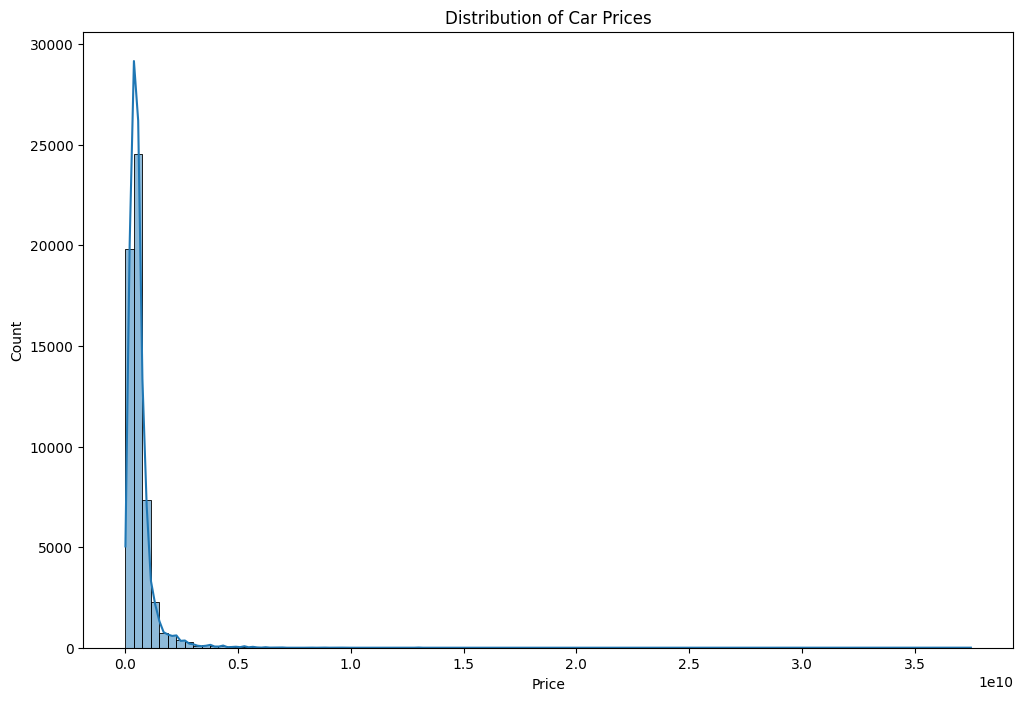

In [41]:
# Visualize the distribution of the target variable
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x='price', bins=100, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

We can see that while most of the car is low price, some cars remain to be higher price, which raise awareness on how these model/brand/type have a very high price, therefore what we are going to do is check for those instances, however, we need to identify them first. 

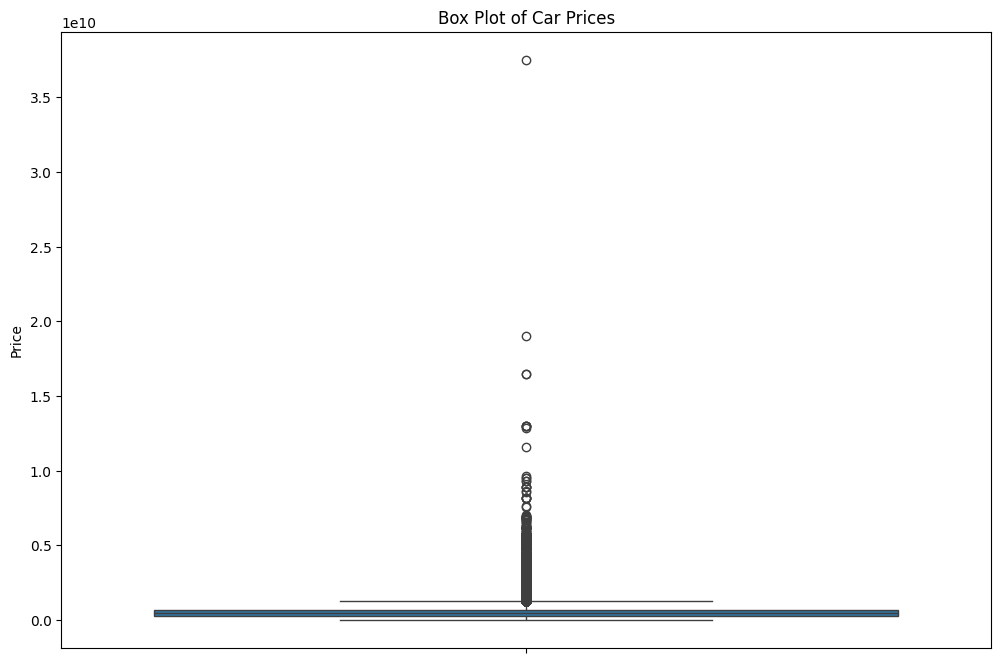

In [42]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, y='price')
plt.title('Box Plot of Car Prices')
plt.ylabel('Price')
plt.show()

In [43]:
# There is lots of outliers in the price column, we can investigate them further, using the IQR method. 
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['price'] < lower_bound) | (data['price'] > upper_bound)]
outliers

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,id_list_id_list_time
56,2023,Hyundai,Dòng khác,Hàn Quốc,SUV / Cross over,7.0,AT,oil,black,0,1.455556e+09,new,150061755_109974753_1694787390000
604,2023,Ford,Everest,Thái Lan,SUV / Cross over,7.0,AT,oil,black,0,1.468000e+09,new,150778078_110591374_1696661396000
701,2023,Ford,Dòng khác,Thái Lan,Pick-up (bán tải),5.0,AT,oil,others,0,1.299000e+09,new,150777822_110591160_1696661027000
1171,2022,Kia,Carnival,Việt Nam,Minivan (MPV),7.0,AT,oil,blue,13000,1.368000e+09,used,149502697_109493513_1695545417680
1261,2022,Kia,Carnival,Việt Nam,Minivan (MPV),7.0,AT,oil,others,13000,1.368000e+09,used,149908816_109842783_1694417069000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
314506,2010,Lexus,GX,Nhật Bản,SUV / Cross over,8.0,AT,petrol,green,90000,1.650000e+09,used,148439187_108590239_1693627124096
314571,2010,Lexus,GX,Nhật Bản,SUV / Cross over,8.0,AT,petrol,green,90000,1.650000e+09,used,148439187_108590239_1696080990000
314870,2015,Mercedes Benz,S Class,Việt Nam,Sedan,5.0,AT,petrol,Unknown,72000,1.295000e+09,used,150934482_110726113_1697076491000
315023,2015,Mercedes Benz,S Class,Việt Nam,Sedan,5.0,AT,petrol,Unknown,72000,1.295000e+09,used,150934482_110726113_1697710086324


In [44]:
# percentage of condition in the outlier
outliers['condition'].value_counts(normalize=True) * 100

condition
used       74.339323
new        25.660677
Unknown     0.000000
Name: proportion, dtype: float64

In [45]:
data['condition'].value_counts(normalize=True) * 100

condition
used       83.682386
new        16.317614
Unknown     0.000000
Name: proportion, dtype: float64

We can see that the ratio for used/new from the outlier versus original data is lower, therefore it is quite right, since new car often have higher price than old car. What if it is the case where the saler overestimate the true value of the car? We need to investigate that at well. We can try and do this by compare the values to the one that is not outlier to see whether they are the same or not. 

In [46]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,id_list_id_list_time
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used,148468232_108616925_1693378633111
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,149864917_109805135_1694308247000
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,148601679_108727914_1693493126176
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,148583720_108712558_1694932494416
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used,150061598_109974620_1694955795249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,150398284_110264477_1695692918000
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used,150748445_110565749_1696580444000
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used,150840647_110645035_1696835873000
317618,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,Unknown,110000,535000000.0,used,148874300_108958993_1696836032000


# Feature Engineering

As with the objective saying above about the model have to perform correctly for brands that made up to 90% of the total car, with that being said, we should focus on brands that made up to the total of 90% of our car. 

In [47]:
# Calculate the proportion of each brand
brand_counts = data['brand'].value_counts(normalize=True).reset_index()
brand_counts.columns = ['brand', 'proportion']

# Calculate the cumulative sum of the proportions
brand_counts['cumulative_sum'] = brand_counts['proportion'].cumsum()

# Define the cutoff value
cutoff = 0.9
brand_counts_below_cutoff = brand_counts[brand_counts['cumulative_sum'] <= cutoff]

brand_counts_below_cutoff

,brand,proportion,cumulative_sum
0,Toyota,0.207786,0.207786
1,Ford,0.129002,0.336788
2,Hyundai,0.121431,0.458220
3,Kia,0.113507,0.571727
4,Mitsubishi,0.063749,0.635476
5,Mercedes Benz,0.061025,0.696501
6,Mazda,0.054976,0.751477
7,Honda,0.053260,0.804737
8,Chevrolet,0.033237,0.837974
9,Vinfast,0.026869,0.864842


Ok so now we know these brands cummulative up to 90% data in our dataset. The objective is to make the model to learn well on this set. Or focus on this set at least.

In [47]:
data = data[data['brand'].isin(brand_counts_below_cutoff['brand'])]
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,id_list_id_list_time
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,149864917_109805135_1694308247000
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,148601679_108727914_1693493126176
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,148583720_108712558_1694932494416
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used,150061598_109974620_1694955795249
7,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used,149562869_109545581_1693401905000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,150398366_110264553_1695693039000
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,150398284_110264477_1695692918000
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used,150840647_110645035_1696835873000
317618,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,Unknown,110000,535000000.0,used,148874300_108958993_1696836032000


So far so good, since now we do not need `id_list_id_list_time`, therefore we will just drop them. 

In [48]:
data=data.drop(columns=['id_list_id_list_time'])
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
7,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used
317618,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,Unknown,110000,535000000.0,used


We can also notice that several encoding method may be suitable for us as well. More specifically, brand, model, origin, type, gearbox and color can all be used with label encoding to transform. Thus, we will find a way to transform them.

In [49]:
from sklearn.preprocessing import LabelEncoder
import joblib

columns_to_encode = ['brand', 'model', 'origin', 'type', 'gearbox', 'color', 'fuel', 'condition']

# Dictionay to store the encoder
encoders = {}

# Perform label encoding and store the encoders
for col in columns_to_encode:
    # Define the label encoders
    le = LabelEncoder()
    # Fit to the data
    le.fit(data[col])
    data[col]=le.transform(list(data[col].values))
    # Save the le to a dict
    encoders[col]=le
    
# Save the encoders
joblib.dump(encoders, f'{MODEL_PATH}/label_encoders.joblib')


['models/label_encoders.joblib']

In [66]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1,2021,3,71,2,7,5.0,1,3,12,23000,455000000.0,1
3,2020,10,251,6,7,5.0,2,3,12,99999,368000000.0,1
5,2022,4,94,6,7,5.0,1,3,12,45000,455000000.0,1
6,2018,10,136,6,6,8.0,2,3,12,60000,485000000.0,1
7,2020,8,268,3,3,7.0,2,3,12,50000,465000000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,4,21,6,7,5.0,2,3,11,12000,350000000.0,1
317607,2017,5,205,6,3,7.0,1,2,12,140000,730000000.0,1
317617,2018,4,126,6,1,5.0,1,3,10,87000,315000000.0,1
317618,2007,4,248,0,6,7.0,1,2,0,110000,535000000.0,1


In [67]:
data.to_csv("data/processed/cleaned_data.csv", index=False)

So far so good, let move on to how can we transform mileage_v2.

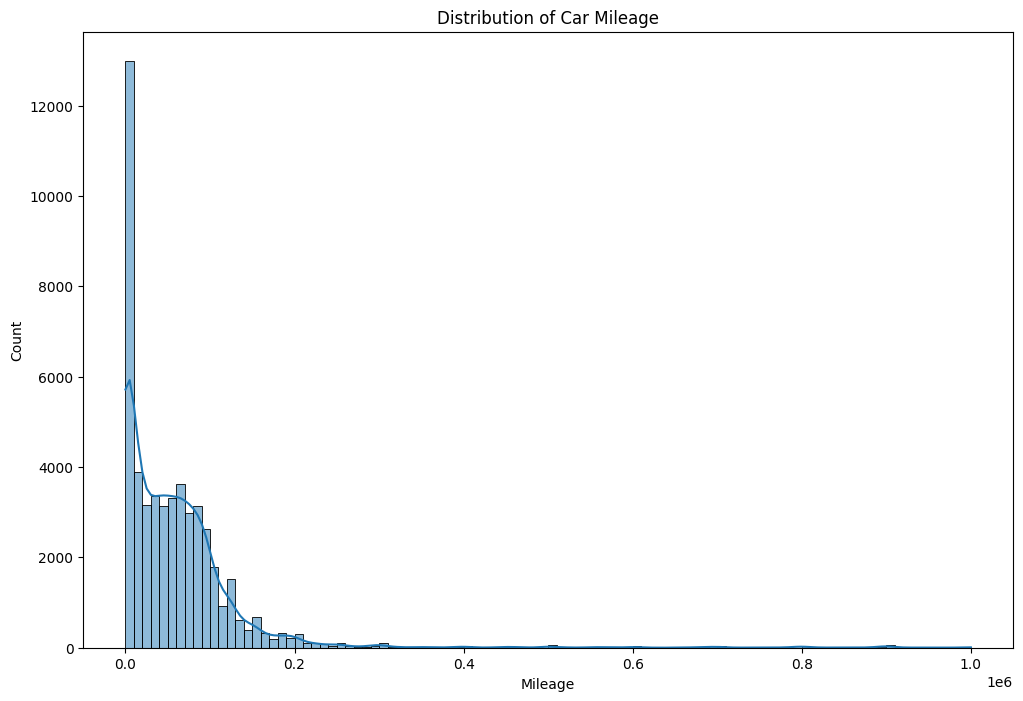

In [51]:
# Visualize the mileage distribution
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x='mileage_v2', bins=100, kde=True)
plt.title('Distribution of Car Mileage')
plt.xlabel('Mileage')
plt.ylabel('Count')
plt.show()


This is heavily skewed, I guest i will just use the log-transformation and stored it.

# Modeling and Evaluation

I will try with catboost, lgbm, xgboost and other regression models as well.

## Train and split test

In [52]:
# Define the features and target variable
X = data.drop(columns=['price'])
y = data['price']

# Split the data into training and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (35597, 11), (35597,)
Validation set: (7628, 11), (7628,)
Test set: (7629, 11), (7629,)


## Try with the baseline first
What we are going to do to establish a baseline is to build a simple model

In [53]:
from dataclasses import MISSING
import xgboost as xgb

# Define the models
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, MISSING=np.nan)

In [54]:
X_train

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,condition
29372,2018,5,67,6,7,5.0,1,3,12,29998,1
18934,2020,7,41,6,7,5.0,1,3,12,28000,1
204454,2020,4,236,6,6,5.0,1,2,12,435012,1
210831,2020,4,21,6,7,5.0,2,3,12,50000,1
236855,2009,4,204,0,6,7.0,1,2,11,150000,1
...,...,...,...,...,...,...,...,...,...,...,...
56044,2023,10,109,6,6,7.0,1,2,12,0,0
280875,2019,6,50,6,6,5.0,1,3,11,62000,1
250549,2015,7,41,6,7,5.0,1,3,0,55000,1
3108,1999,10,273,2,6,8.0,2,3,2,222222,1


In [55]:
y_train

29372     4.660000e+08
18934     1.189000e+09
204454    7.500000e+08
210831    4.750000e+08
236855    4.150000e+08
              ...     
56044     1.118000e+09
280875    6.380000e+08
250549    7.390000e+08
3108      8.900000e+07
106494    2.680000e+08
Name: price, Length: 35597, dtype: float64

In [56]:
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True, missing=np.NAN)
dval= xgb.DMatrix(X_val, label=y_val, enable_categorical=True, missing=np.NAN)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True, missing=np.NAN)

Since XGBoost need to specify to allow NaN, we have to create NaN for it as well.

In [57]:
xgb_params = {
    'objective': 'reg:squarederror',  # or any other objective
    'max_depth': 10,
    'eta': 0.3,
    'enable_categorical': True
}

/home/ngnqaq/anaconda3/envs/xai-venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:26:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: 4049120262350784.5
R^2 Score: 0.9843366458744587
Mean Absolute Error: 16589322.352864072


/home/ngnqaq/anaconda3/envs/xai-venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:26:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


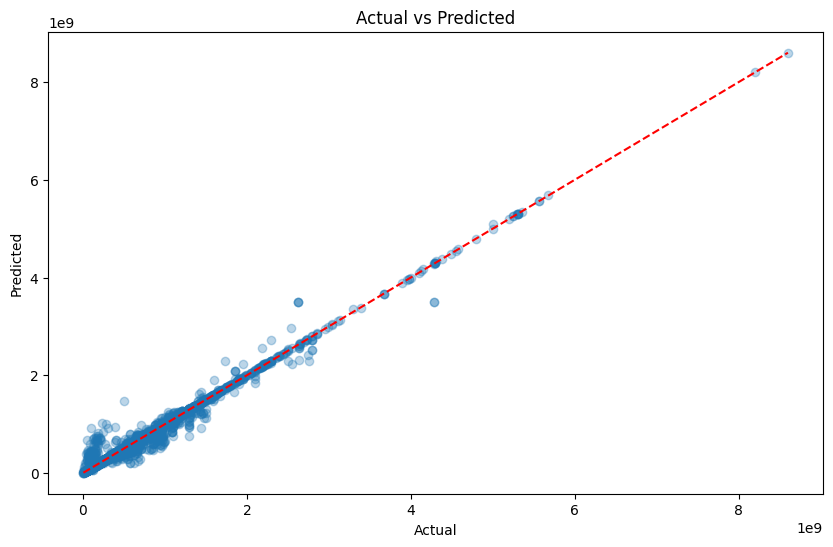

In [58]:
xgb_model=xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=0)
# Predict on the test set
y_pred = xgb_model.predict(dtest)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")

# Cross-Validation
cv_results = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=5, metrics="rmse", as_pandas=True, seed=42)
cv_results
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

The model handling outlier quite good, some wrong prediction at the start, dont know why

In [59]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,4.089966e+08,1.446123e+07,4.092494e+08,7.083777e+07
1,3.361910e+08,1.905390e+07,3.379636e+08,7.712284e+07
2,2.798260e+08,1.911899e+07,2.911853e+08,8.414007e+07
3,2.459800e+08,2.006589e+07,2.624936e+08,8.904272e+07
4,2.210476e+08,1.940896e+07,2.446109e+08,9.282019e+07
...,...,...,...,...
95,7.069919e+07,3.191468e+06,1.959855e+08,1.056618e+08
96,7.057330e+07,3.177560e+06,1.959710e+08,1.056546e+08
97,7.047581e+07,3.156889e+06,1.959578e+08,1.056524e+08
98,7.035818e+07,3.149595e+06,1.959495e+08,1.056573e+08


In [60]:
# Anyway, save the model first, then try to build api for this model
import joblib
joblib.dump(xgb_model, f"{MODEL_PATH}/model_xgb.joblib")

['models/model_xgb.joblib']

The result is quite ok, the R^2 is quite high tho. Let move on to catboost

In [62]:
from catboost import CatBoostRegressor, Pool
categorical_features = data.select_dtypes(include='category').columns.tolist()
# convert data to str
df = data.copy() 
# Convert NaN values in categorical features to strings
df[categorical_features] = df[categorical_features].astype(str)
# Prepare data for CatBoost
X = df.drop(columns=['price'], axis=1)  # Replace 'target_column' with your target column name
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Pool for CatBoost
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)


In [63]:
# Define the model params
cat_params = {
    'loss_function': 'MAE',
    'iterations': 1000,
    'learning_rate': 0.01,
    'cat_features': categorical_features,
    'verbose': 100
}

0:	learn: 274957164.2955293	total: 80.9ms	remaining: 1m 20s
100:	learn: 195794666.1505585	total: 1.1s	remaining: 9.78s
200:	learn: 164988317.7992624	total: 2.46s	remaining: 9.79s
300:	learn: 143905047.0006413	total: 3.61s	remaining: 8.38s
400:	learn: 130658771.5894343	total: 5.33s	remaining: 7.96s
500:	learn: 123651961.0900211	total: 7.07s	remaining: 7.04s
600:	learn: 116192270.8203553	total: 8.87s	remaining: 5.89s
700:	learn: 111838382.1296485	total: 9.87s	remaining: 4.21s
800:	learn: 109315527.9978469	total: 10.9s	remaining: 2.72s
900:	learn: 106558848.1762353	total: 11.9s	remaining: 1.31s
999:	learn: 104563682.8226689	total: 12.7s	remaining: 0us
Mean Squared Error: 2.342596636194572e+17
R^2 Score: 0.4037653234698356


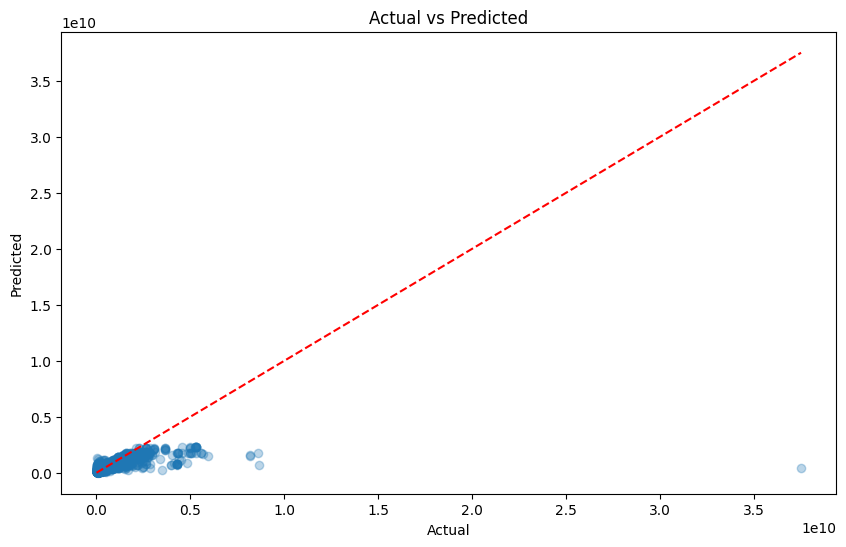

In [64]:
# Train the model
model = CatBoostRegressor(**cat_params)
model.fit(train_pool)

# Predict on the test set
y_pred = model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

Hmmmmm, even worse than xgboost, let move on and try with lgbm

In [70]:
import lightgbm as lgb

# Define parameters
lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [71]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [73]:
lgbm_model = lgb.train(lgbm_params, train_data, num_boost_round=1000, valid_sets=[train_data, test_data])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 40683, number of used features: 11
[LightGBM] [Info] Start training from score 572711166.323206


In [74]:
y_pred = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

In [76]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 1.5912525041791014e+17
Mean Absolute Error: 60627612.105348706
R^2 Score: 0.5949964635617968
